<a href="https://colab.research.google.com/github/hcorzopola/madagascar/blob/master/SFX_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using Madagascar in Google Colab**

1. Download the binary distribution

In [1]:
!wget https://reproducibility.org/wikilocal/colab/madagascar.tar.gz

--2024-10-06 15:56:45--  https://reproducibility.org/wikilocal/colab/madagascar.tar.gz
Resolving reproducibility.org (reproducibility.org)... 208.113.191.116
Connecting to reproducibility.org (reproducibility.org)|208.113.191.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84455983 (81M) [application/gzip]
Saving to: ‘madagascar.tar.gz’

madagascar.tar.gz   100%[===================>]  80.54M  70.3MB/s    in 1.1s    

2024-10-06 15:56:46 (70.3 MB/s) - ‘madagascar.tar.gz’ saved [84455983/84455983]



2. Unpack

In [2]:
!tar xzf madagascar.tar.gz -C /

3. Set environmental variables

In [3]:
%env RSFROOT=/content/RSFROOT
%env PYTHONPATH=/content/RSFROOT/lib/python3.10/site-packages
%env LD_LIBRARY_PATH=/content/RSFROOT/lib
%env DATAPATH=/content/RSFROOT/data/
%env PATH=/content/RSFROOT/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:

env: RSFROOT=/content/RSFROOT
env: PYTHONPATH=/content/RSFROOT/lib/python3.10/site-packages
env: LD_LIBRARY_PATH=/content/RSFROOT/lib
env: DATAPATH=/content/RSFROOT/data/
env: PATH=/content/RSFROOT/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:


Make sure that the Python interface is accessible.

In [4]:
import sys, os
sys.path.append(os.environ.get('PYTHONPATH'))

4. Load Python interface to Madagascar

In [5]:
from m8r import view

## **Fetch data**

In [6]:
%%file fetch.scons

# Fetch & plot dataset
Fetch('elf-stk2.rsf','masha')
Flow('original','elf-stk2','dd form=native | put unit1=s')
Result('original','grey title="Original data"')

Flow('decimated','original','window j2=2')
Result('decimated','grey title="Decimated data"')

Writing fetch.scons


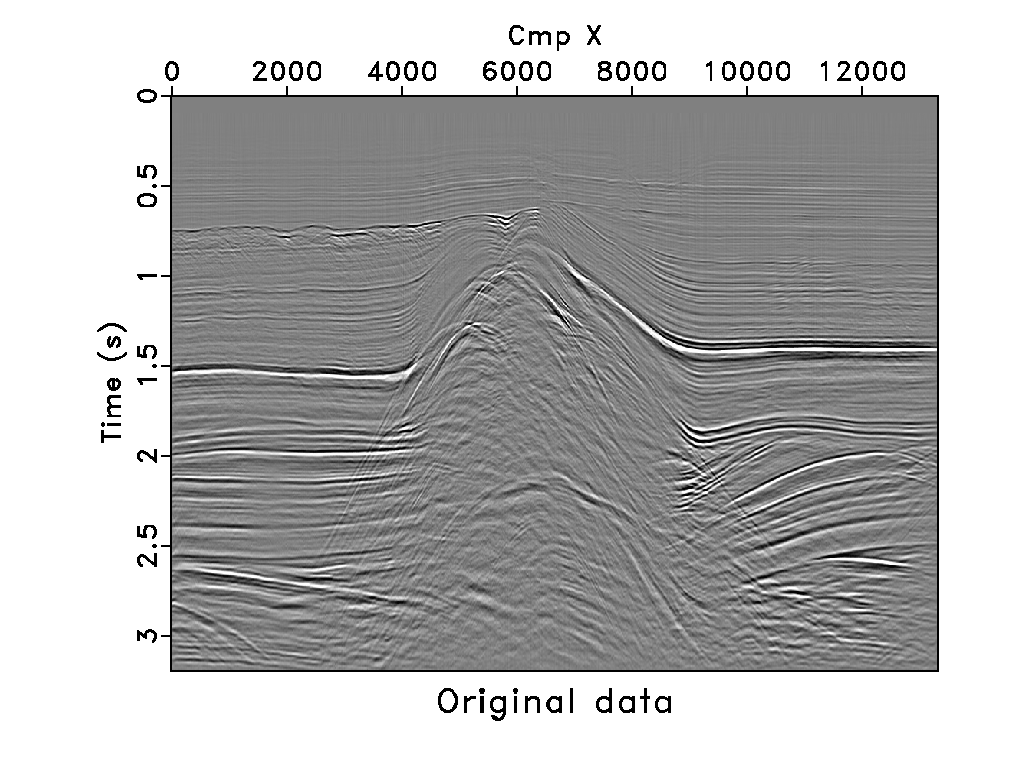

In [7]:
view('original')

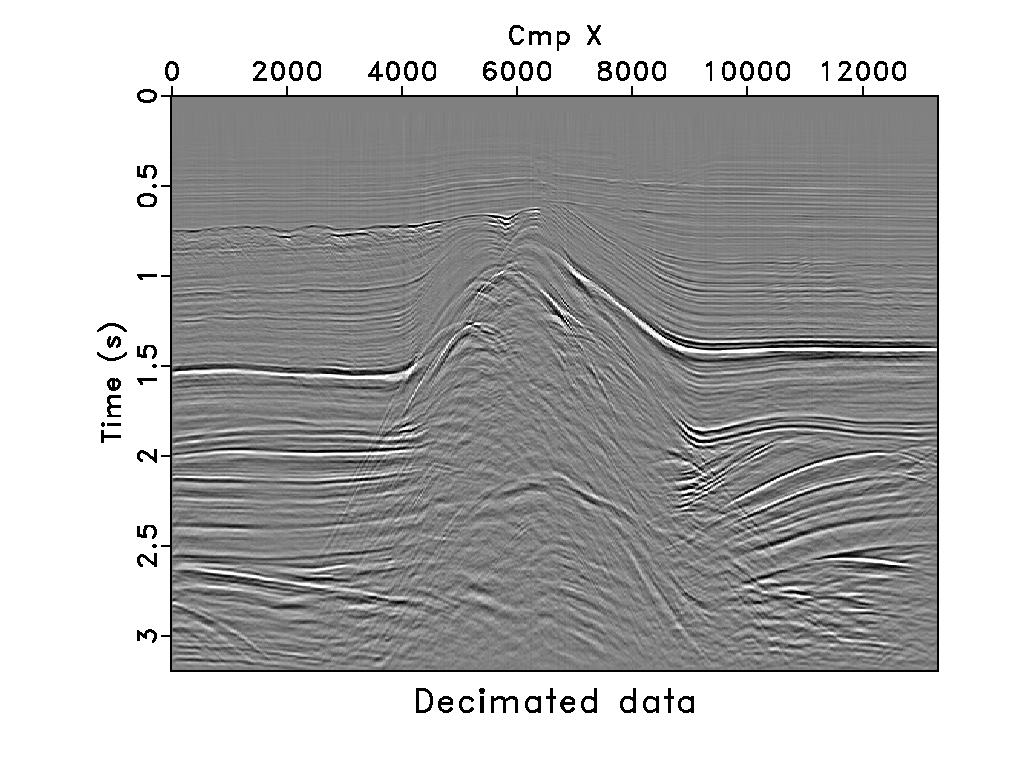

In [8]:
view('decimated')

## **Fourier transform and patching**

In [9]:
%%file fourier.scons

Flow('fx_original','decimated','fft1')
Result('fx_original','math output="abs(input)" | real | grey title="Original data"')

Flow('patch_real','fx_original','real | window n1=201 | patch w=1,11 p=201,69')
Flow('patch_imag','fx_original','imag | window n1=201 | patch w=1,11 p=201,69')

Flow('patch','patch_real patch_imag','cat axis=1 ${SOURCES[1]} | transp plane=12')

Flow('ipatch_real','fx_original','real | pad n2=501 | patch w=1,6 p=401,100')
Flow('ipatch_imag','fx_original','imag | pad n2=501 | patch w=1,6 p=401,100')

Flow('ipatch','ipatch_real ipatch_imag','cat axis=1 ${SOURCES[1]} | transp plane=12')

Writing fourier.scons


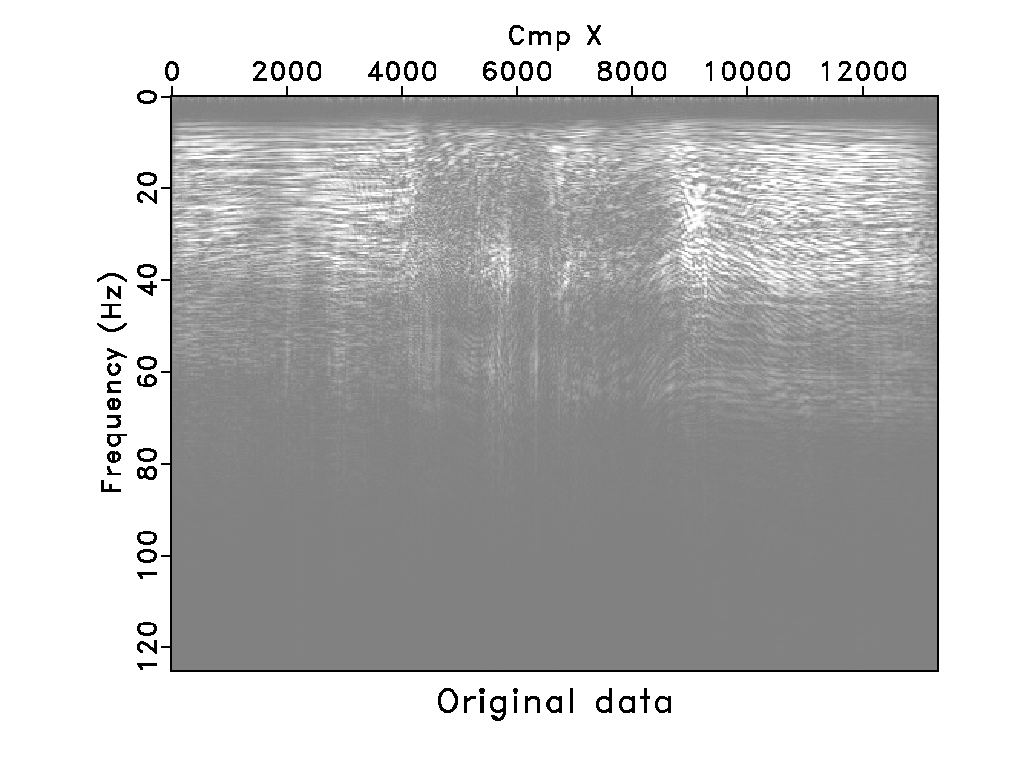

In [10]:
view('fx_original')

In [11]:
!scons patch.rsf -f SConstruct.jupyter

scons: Reading SConscript files ...
scons: done reading SConscript files.
scons: Building targets ...
< fx_original.rsf /content/RSFROOT/bin/sfreal | /content/RSFROOT/bin/sfwindow n1=201 | /content/RSFROOT/bin/sfpatch w=1,11 p=201,69 > patch_real.rsf
< fx_original.rsf /content/RSFROOT/bin/sfimag | /content/RSFROOT/bin/sfwindow n1=201 | /content/RSFROOT/bin/sfpatch w=1,11 p=201,69 > patch_imag.rsf
< patch_real.rsf /content/RSFROOT/bin/sfcat axis=1 patch_imag.rsf | /content/RSFROOT/bin/sftransp plane=12 > patch.rsf
scons: done building targets.


In [12]:
import m8r
import numpy as np

patch = m8r.File('patch.rsf')
patchnp = patch[:]
patch_reshaped = np.reshape(patchnp, (69*201,2,11))

patch_input = patch_reshaped[:,:,::2]
patch_output = patch_reshaped[:,:,1::2]

## **Fully connected neural network**

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from sklearn.model_selection import train_test_split

# Input: size (2, 9) -- meaning 9 features with 2 channels
# Output: size (2, 8) -- meaning 8 features with 2 channels

# Generating random data
x = patch_input  # Input data
y = patch_output  # Output data

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Define the fully connected neural network model
model = Sequential()

# Flatten the (2, 9) input to a vector of size 16 (2 * 8)
model.add(Flatten(input_shape=(2, 6)))

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output layer: size 14 (2 * 7)
model.add(Dense(10, activation='linear'))

# Reshape output back to (2, 7)
model.add(Reshape((2, 5)))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with external validation set
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

# Evaluate the model
test_loss, test_mae = model.evaluate(x_val, y_val)
print(f"Validation Mean Absolute Error: {test_mae:.4f}")

# Predict using the model
predictions = model.predict(x_val)
print(f"Predictions shape: {predictions.shape}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


347/347 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13724171632640.0000 - mae: 2359339.0000 - val_loss: 3127488544768.0000 - val_mae: 1174649.7500
Epoch 2/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2966803447808.0000 - mae: 1146816.5000 - val_loss: 2697322037248.0000 - val_mae: 1078817.7500
Epoch 3/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2693990711296.0000 - mae: 1074275.7500 - val_loss: 2606142586880.0000 - val_mae: 1055831.6250
Epoch 4/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2670765801472.0000 - mae: 1062410.6250 - val_loss: 2538453598208.0000 - val_mae: 1039233.5625
Epoch 5/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2490695680000.0000 - mae: 1038198.3750 - val_loss: 2519391797248.0000 - val_mae: 1032998.5000
Epoch 6/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2539451318272.0000 - mae: 1040650.7500 - val_loss: 2503537852416.0000 - val_mae: 1030735.4375
Epoch 7/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2441786163200.0000 - mae: 

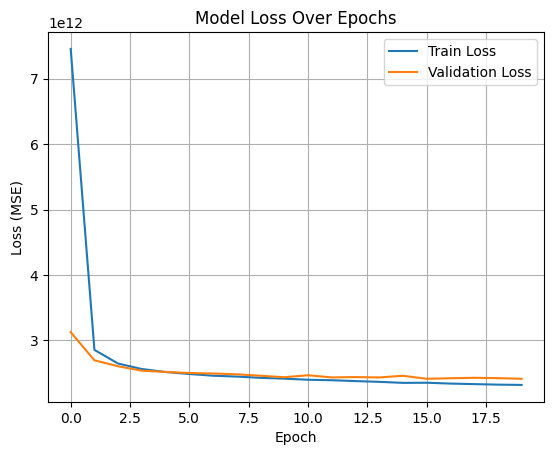

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
normalizeFactor = np.linalg.norm(patch_reshaped.flatten(), 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


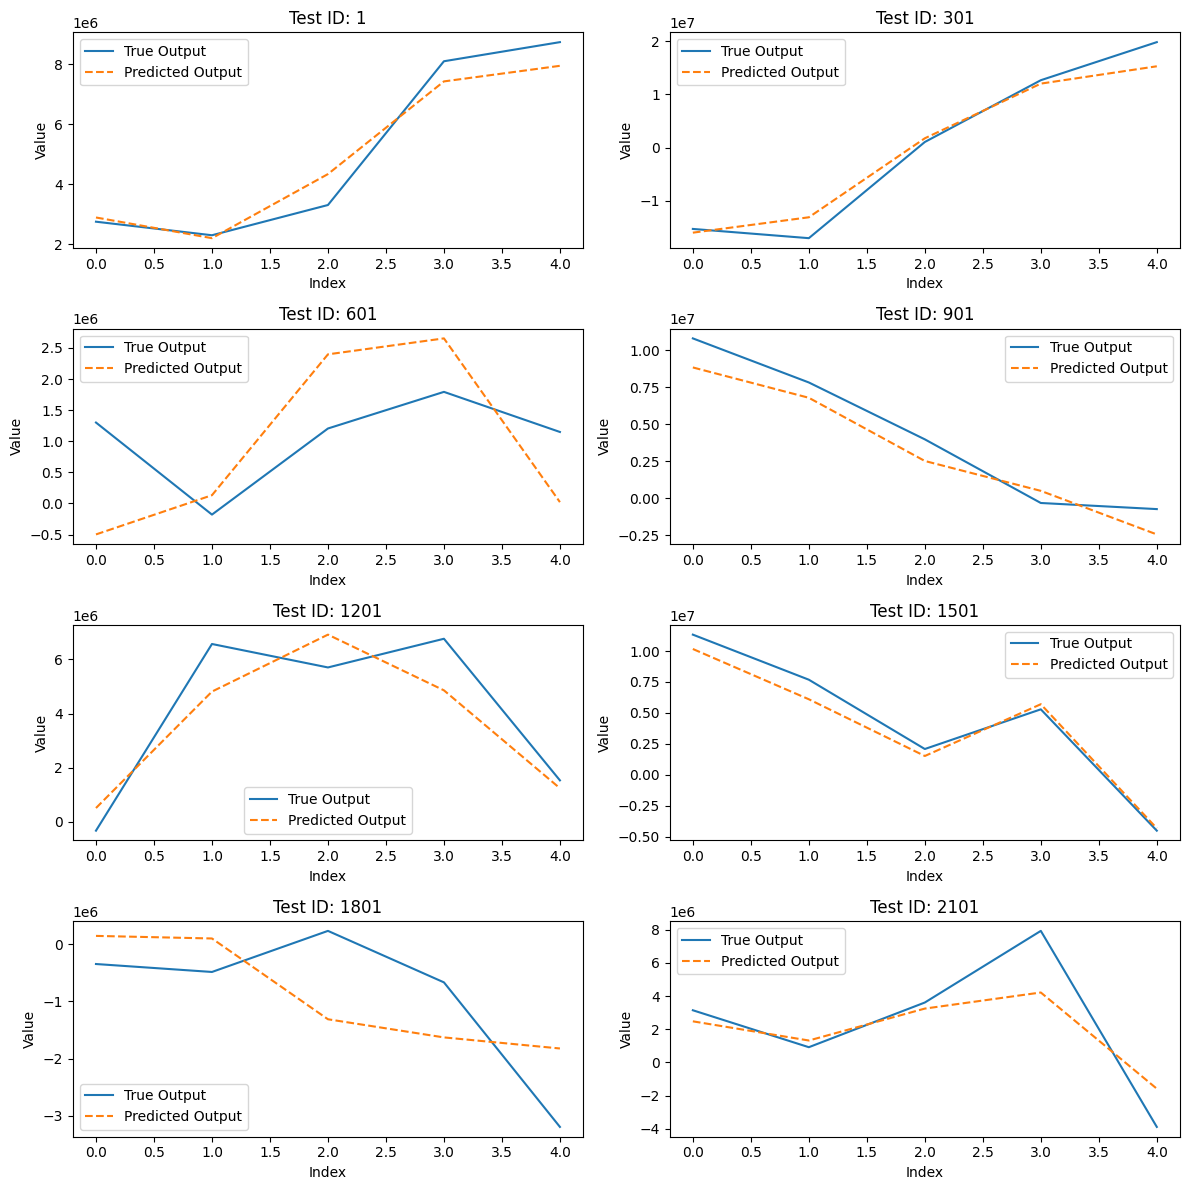

In [15]:
# Let's assume we want to compare 8 different test IDs
test_ids = [1, 301, 601, 901, 1201, 1501, 1801, 2101]

# Create a 4x2 plot grid
fig, axs = plt.subplots(4, 2, figsize=(12, 12))  # 4 rows, 2 columns of subplots

# Flatten the axs array for easier indexing
axs = axs.ravel()

for i, test_id in enumerate(test_ids):
    # Extract the true and predicted outputs for the given test_id
    test_output = y_val[test_id, :, :]
    pred_output = model.predict(x_val[test_id:test_id+1, :, :])

    # Plot on the ith subplot
    axs[i].plot(test_output[0, :], label='True Output')
    axs[i].plot(pred_output[0, 0, :], label='Predicted Output', linestyle='--')

    # Add title and labels
    axs[i].set_title(f'Test ID: {test_id}')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')

    # Add a legend
    axs[i].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

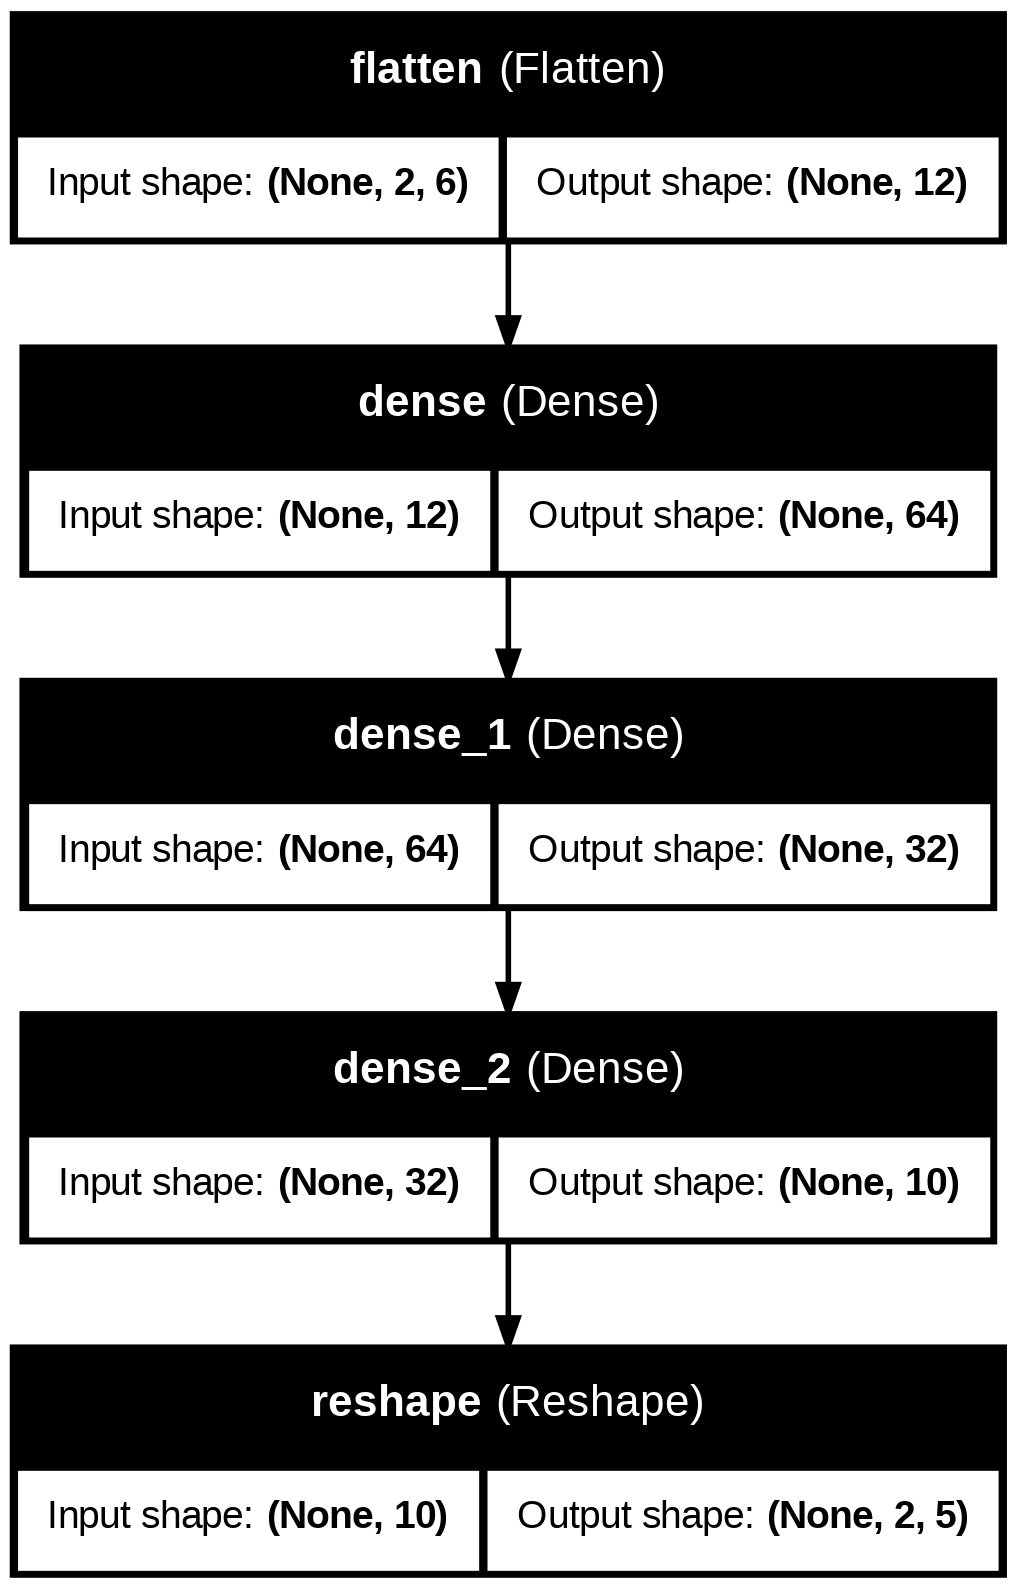

In [38]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

## **Interpolating traces**

In [27]:
!scons ipatch.rsf -f SConstruct.jupyter

scons: Reading SConscript files ...
scons: done reading SConscript files.
scons: Building targets ...
scons: `ipatch.rsf' is up to date.
scons: done building targets.


In [29]:
patch2 = m8r.File('ipatch.rsf')
patchnp2 = patch2[:]
patch_input2 = np.reshape(patchnp2, (100*401,2,6))

In [30]:
patch_pred = model.predict(patch_input2)

1254/1254 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [31]:
patch_pred.shape

(40100, 2, 5)

In [32]:
patch_pred_reshaped = np.reshape(patch_pred, (100,401,2,5))

In [33]:
out = m8r.Output("interpolated.rsf")
out.put("n1",5)
out.put("n2",2)
out.put("n3",401)
out.put("n4",100)
out.write(patch_pred_reshaped)
out.close()

In [34]:
%%file reconstruction.scons

Flow('interpolated_reshaped','interpolated','transp plane=12 | transp plane=34 | put n2=500 n3=401 n4=1 | dd type=complex | window | transp')
Flow('fx_interpolated','fx_original interpolated_reshaped','interleave axis=2 ${SOURCES[1]}')

Result('fx_interpolated','math output="abs(input)" | real | grey title="Interpolated data"')

Flow('tx_interpolated','fx_interpolated','fft1 inv=y')
Result('tx_interpolated','grey title="Interpolated data" clip=664152')

Flow('interpolation_error','original tx_interpolated','add scale=1,-1 ${SOURCES[1]}')
Result('interpolation_error','grey title="Interpolation error" clip=664152')

Overwriting reconstruction.scons


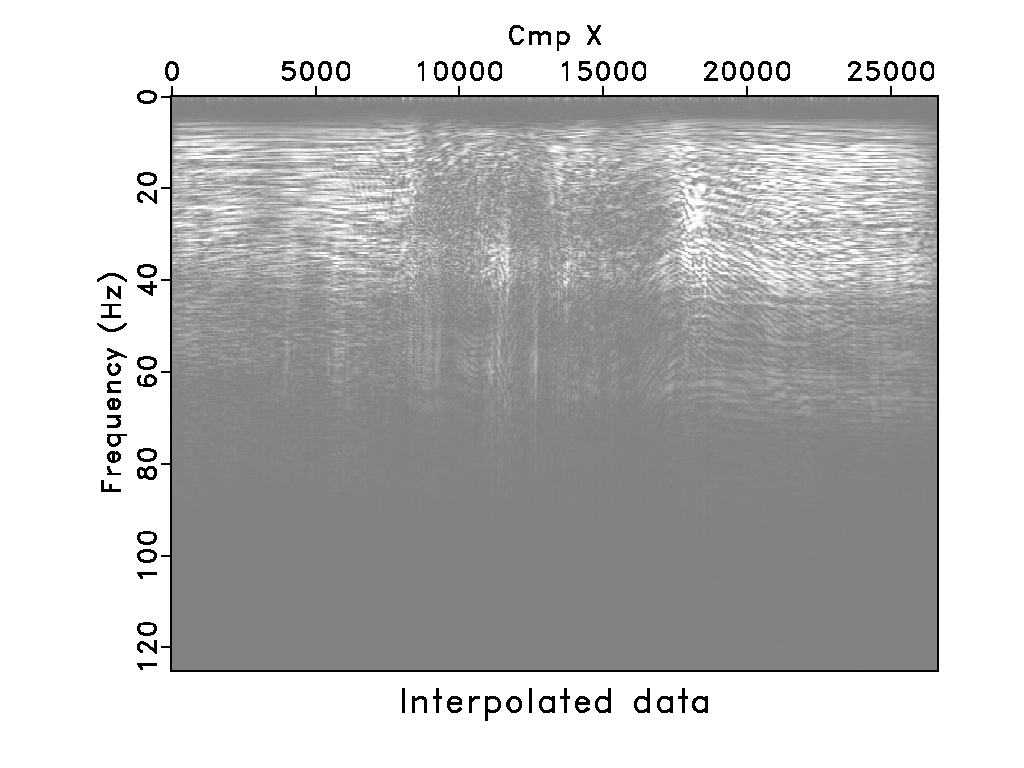

In [35]:
view('fx_interpolated')

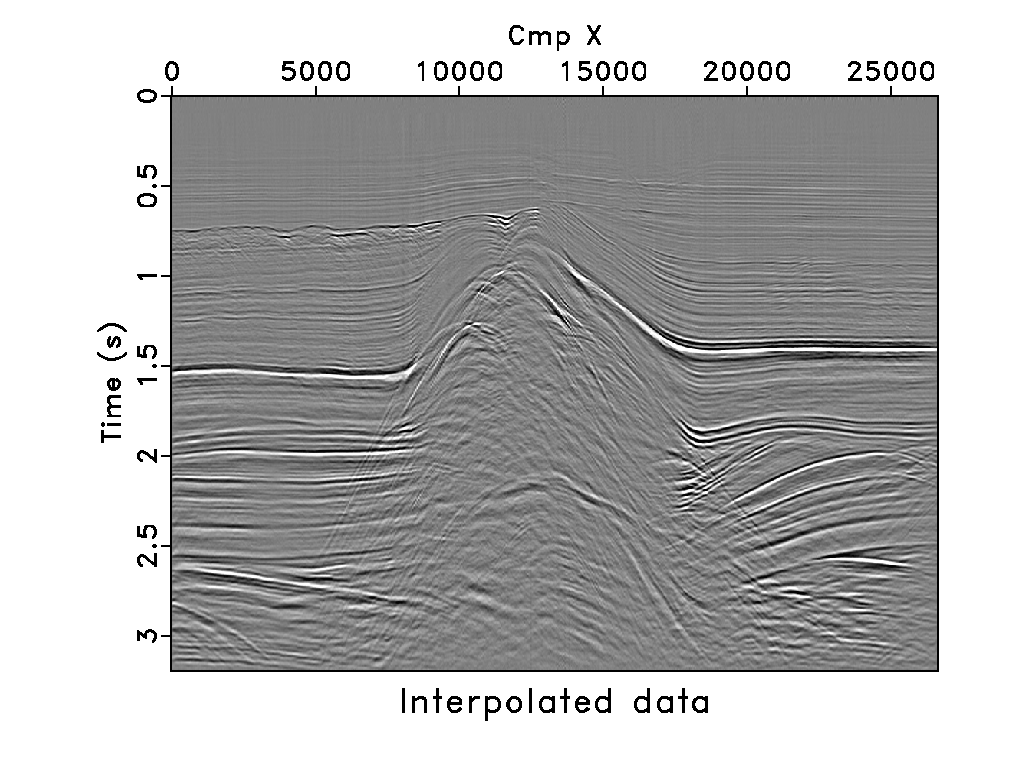

In [36]:
view('tx_interpolated')

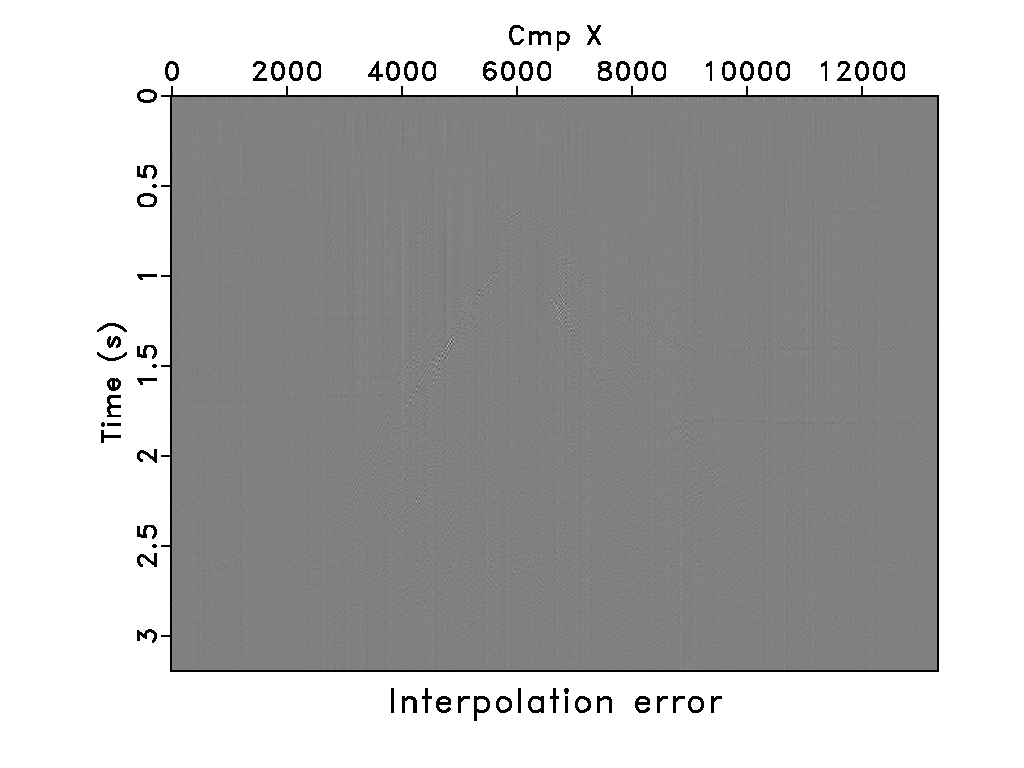

In [37]:
view('interpolation_error')